# 2D EM Simulation

In [54]:
import os
import sys
os.environ["CUDA_VISIBLE_DEVICES"] = "4"
sys.path.append("/disk/student/shuhua/pinnfwi/pinn_helmholtz_elastic/2D_EM_Simulation")
import SIREN_PINN as SP


import torch
import numpy as np
import matplotlib.pyplot as plt

In [55]:
import importlib
importlib.reload(SP)

<module 'SIREN_PINN' from '/disk/student/shuhua/pinnfwi/pinn_helmholtz_elastic/2D_EM_Simulation/SIREN_PINN.py'>

In [56]:
torch.manual_seed(42)
np.random.seed(42)


In [57]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')




n1 = 200  #nx
n2 = 200  #nz
d1 = 0.01
d2 = 0.01
npml = 20

# f = 0.5  # Frequency  # 0.015-0.15 -> omega 0.1 - 1
# f = 1
f = 5
PI = 3.1415926
omega = 2.0 * PI * f # Angular frequency

print(omega)

sigma=3.0

niter = 100000 #Adam iterations
lr = 1e-4 # Adam learning rate
lbfgs_max_iter = 30000 # LBFGS iterations


n1_s = 40 # Source locations
n2_s = 40

perm_model = SP.generate_permittivity_model(n1, n2)
pmla, pmlb, pmlc = SP.generate_boundary_coeff(n1, n2, npml, f, f)
point_source = SP.generate_point_source(n1, 
                                        n2, 
                                        n1_s, 
                                        n2_s, 
                                        sigma, 
                                        max_amplitude=100.0, 
                                        apply_threshold=True)
grid_n1, grid_n2 = SP.generate_mesh_grid(n1, n2, d1, d2)

da_dx, da_dy = torch.gradient(torch.tensor(pmla), spacing=(d1, d2))
db_dx, db_dy = torch.gradient(torch.tensor(pmlb), spacing=(d1, d2))
da_dx = da_dx.numpy()
da_dy = da_dy.numpy()
db_dx = db_dx.numpy()
db_dy = db_dy.numpy()

m = SP.prepare_data_training(perm_model)
A = SP.prepare_data_training(pmla)
B = SP.prepare_data_training(pmlb)
C = SP.prepare_data_training(pmlc)
ps = SP.prepare_data_training(point_source)
g1 = SP.prepare_data_training(grid_n1)
g2 = SP.prepare_data_training(grid_n2)

da_dx_p = SP.prepare_data_training(da_dx)
da_dy_p = SP.prepare_data_training(da_dy)
db_dx_p = SP.prepare_data_training(db_dx)
db_dy_p = SP.prepare_data_training(db_dy)

print(da_dx_p.shape, da_dy_p.shape, db_dx_p.shape, db_dy_p.shape)


N = m.shape[0]
idx = np.random.choice(N, int(N), replace=False)


pinn_model = SP.PINN(
    g1[idx, :], g2[idx, :],
    A[idx, :], B[idx, :], C[idx, :],
    ps[idx, :], m[idx, :],
    omega, da_dx_p[idx, :], db_dy_p[idx, :], lr,
    niter,
    lbfgs_max_iter = lbfgs_max_iter,
    in_features=2, 
    hidden_features=40, 
    hidden_layers=8, 
    out_features=2, 
    w0=1.0, 
    w0_initial=30.0,  # SIREN specific
    device=device,
).to(device)

print("Start training")
loss_all = pinn_model.train_model()
print("End training")

print("Prediction")
# Prediction
u_real_pred, u_imag_pred = pinn_model.predict(g1, g2)



31.415926
lx shape: (200, 200)
lz shape: (200, 200)
Mesh grid shapes: (200,) (200,)
(40000, 1) (40000, 1) (40000, 1) (40000, 1)
Start training
Epoch 0, Loss: 1.4140e+11, Time: 0.03s
Epoch 1000, Loss: 7.4143e+08, Time: 31.54s
Epoch 2000, Loss: 2.8077e+08, Time: 31.66s
Epoch 3000, Loss: 1.6308e+08, Time: 31.78s
Epoch 4000, Loss: 1.1168e+08, Time: 31.80s
Epoch 5000, Loss: 8.4696e+07, Time: 31.84s
Epoch 6000, Loss: 6.9627e+07, Time: 31.83s
Epoch 7000, Loss: 5.8873e+07, Time: 31.82s
Epoch 8000, Loss: 4.8904e+07, Time: 31.86s
Epoch 9000, Loss: 4.0222e+07, Time: 31.84s
Epoch 10000, Loss: 3.2602e+07, Time: 31.83s
Epoch 11000, Loss: 2.5489e+07, Time: 31.85s
Epoch 12000, Loss: 2.0067e+07, Time: 31.85s
Epoch 13000, Loss: 1.6830e+07, Time: 31.83s
Epoch 14000, Loss: 1.5006e+07, Time: 31.84s
Epoch 15000, Loss: 1.3806e+07, Time: 31.82s
Epoch 16000, Loss: 1.2948e+07, Time: 31.81s
Epoch 17000, Loss: 1.2664e+07, Time: 31.82s
Epoch 18000, Loss: 1.1792e+07, Time: 31.83s
Epoch 19000, Loss: 1.1379e+07, Time

# To-do 
### PDE Loss
### 

In [58]:
grid_n1.shape, grid_n2.shape, perm_model.shape, point_source.shape, pmla.shape, pmlb.shape, pmlc.shape, m.shape, A.shape, B.shape, C.shape, da_dx_p.shape, da_dy_p.shape, db_dx_p.shape, db_dy_p.shape

((200, 200),
 (200, 200),
 (200, 200),
 (200, 200),
 (200, 200),
 (200, 200),
 (200, 200),
 (40000, 1),
 (40000, 1),
 (40000, 1),
 (40000, 1),
 (40000, 1),
 (40000, 1),
 (40000, 1),
 (40000, 1))

In [59]:
for name, param in pinn_model.model.named_parameters():
    if param.requires_grad:  # Check if the parameter is trainable
        print(f"Layer: {name}, Shape: {param.shape}")
        print(f"Weights/Biases:\n{param.data}")

Layer: net.0.weight, Shape: torch.Size([40, 2])
Weights/Biases:
tensor([[-0.0225, -0.1726],
        [-0.0165, -0.3011],
        [-0.2919, -0.2874],
        [-0.2012, -0.3708],
        [ 0.4039, -0.0914],
        [ 0.3724,  0.1183],
        [-0.4081,  0.3146],
        [-0.1371, -0.1808],
        [-0.3724, -0.4466],
        [ 0.1123, -0.0863],
        [ 0.1793, -0.3737],
        [ 0.3190, -0.2974],
        [-0.0983,  0.0817],
        [ 0.2196,  0.3707],
        [ 0.4095, -0.3122],
        [ 0.1346, -0.1857],
        [-0.0578, -0.3397],
        [ 0.4099, -0.3109],
        [ 0.2453,  0.1468],
        [ 0.1443, -0.2264],
        [ 0.3857,  0.1264],
        [ 0.0864, -0.3890],
        [ 0.2005, -0.0554],
        [-0.1891,  0.3815],
        [ 0.1274, -0.2515],
        [-0.2137, -0.0115],
        [ 0.2749, -0.1107],
        [-0.2422, -0.1647],
        [-0.3406,  0.1149],
        [ 0.3504, -0.3889],
        [ 0.1070,  0.2230],
        [ 0.0893, -0.1270],
        [ 0.2453,  0.2542],
        [ 0.

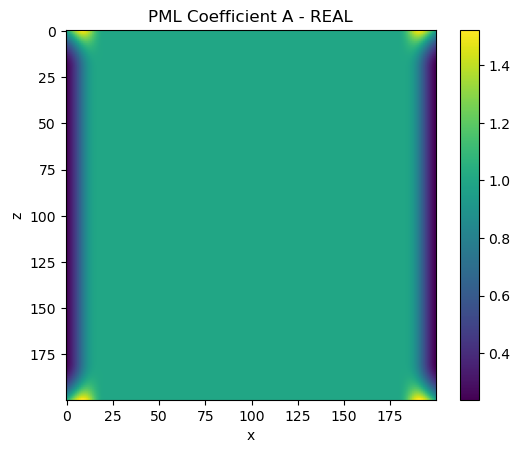

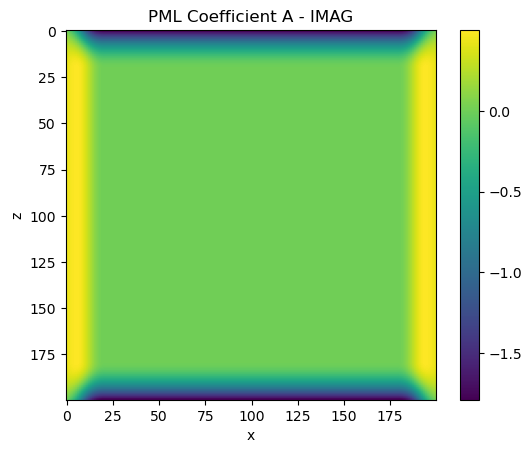

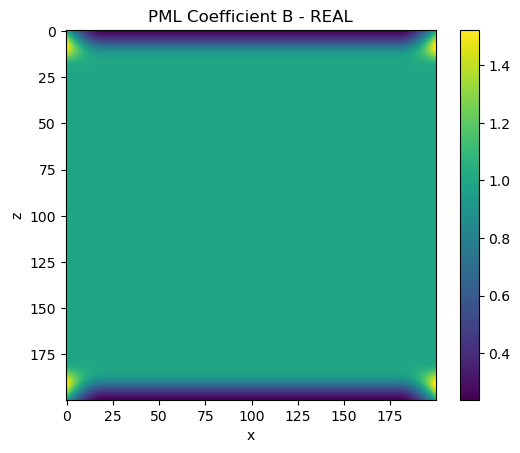

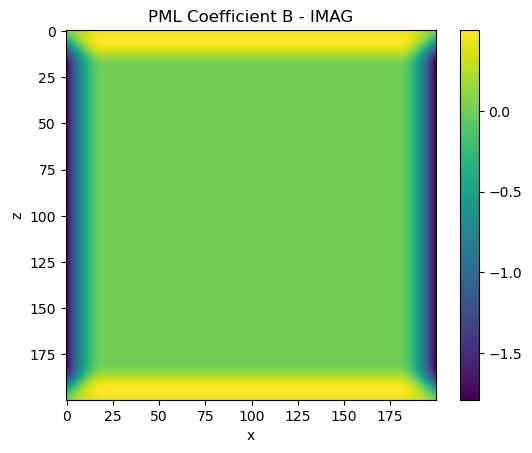

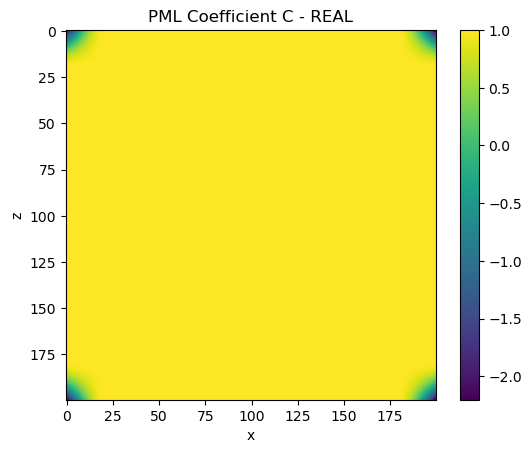

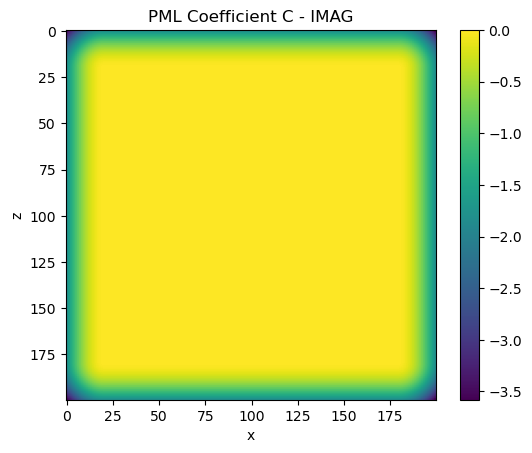

In [60]:
plt.imshow(pmla.real.T)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("z")
plt.title("PML Coefficient A - REAL")
plt.show()


# plt.imshow(da_dx.real.T, origin='lower')
# plt.colorbar()
# plt.title("Gradient of PML Coefficient A (x-direction, REAL)")
# plt.xlabel("x")
# plt.ylabel("z")
# plt.show()

# plt.imshow(da_dy.real.T, origin='lower')
# plt.colorbar()
# plt.title("Gradient of PML Coefficient A (y-direction, REAL)")
# plt.xlabel("x")
# plt.ylabel("z")
# plt.show()


plt.imshow(pmla.imag.T)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("z")
plt.title("PML Coefficient A - IMAG")
plt.show()



# plt.imshow(da_dx.imag.T, origin='lower')
# plt.colorbar()
# plt.title("Gradient of PML Coefficient A (x-direction, IMAG)")
# plt.xlabel("x")
# plt.ylabel("z")
# plt.show()

# plt.imshow(da_dy.imag.T, origin='lower')
# plt.colorbar()
# plt.title("Gradient of PML Coefficient A (y-direction, IMAG)")
# plt.xlabel("x")
# plt.ylabel("z")
# plt.show()


plt.imshow(pmlb.real.T)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("z")
plt.title("PML Coefficient B - REAL")
plt.show()


plt.imshow(pmlb.imag.T)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("z")
plt.title("PML Coefficient B - IMAG")
plt.show()


plt.imshow(pmlc.real.T)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("z")
plt.title("PML Coefficient C - REAL")
plt.show()


plt.imshow(pmlc.imag.T)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("z")
plt.title("PML Coefficient C - IMAG")
plt.show()




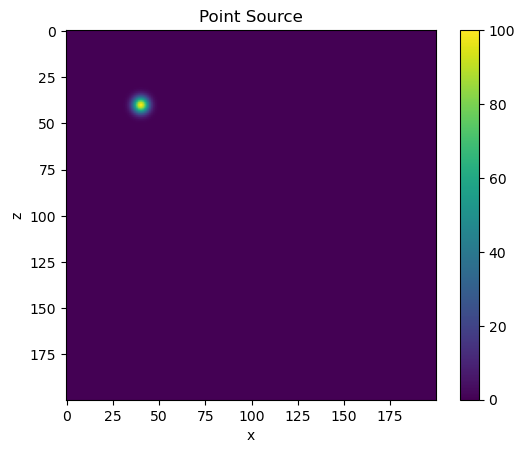

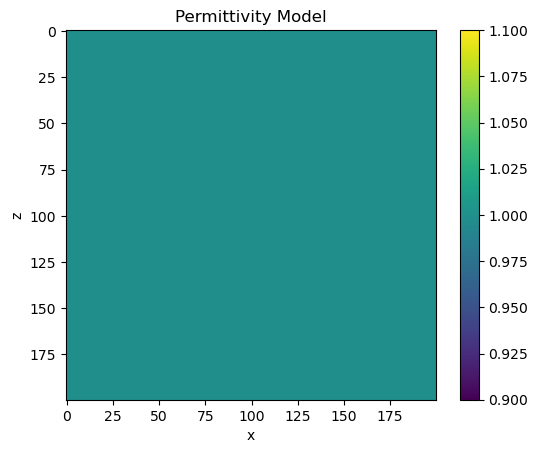

In [61]:

plt.imshow(point_source.T)
plt.title("Point Source")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("z")
plt.show()

plt.imshow(perm_model.T)
plt.title("Permittivity Model")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("z")
plt.show()

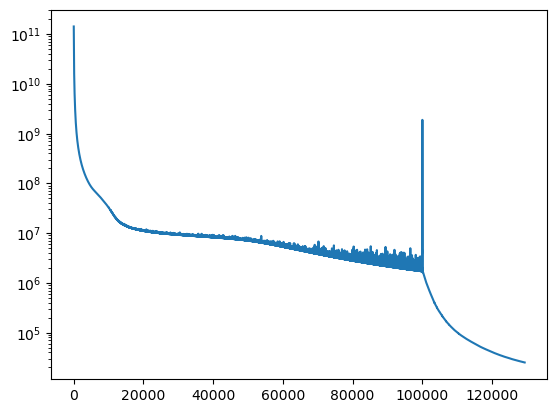

In [62]:
plt.plot(loss_all)
plt.yscale('log')

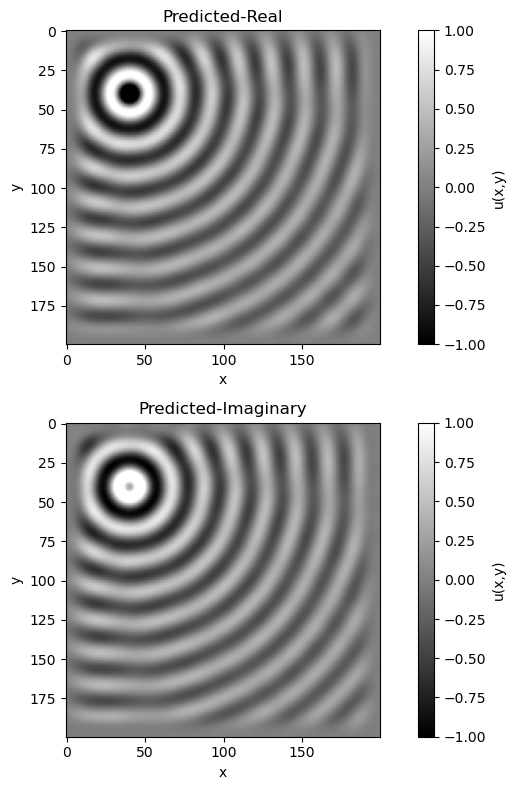

In [63]:
plt.figure(figsize=(8, 8))

vmin = -1
vmax = -vmin

# cmap = 'viridis's
cmap = 'gray'

plt.subplot(2, 1, 1)
plt.imshow(u_real_pred.reshape([n1, n2]).T, aspect='equal', cmap=cmap, vmin=vmin, vmax=vmax)
# plt.gca().set_aspect('equal')
plt.colorbar(label='u(x,y)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Predicted-Real')

plt.subplot(2, 1, 2)
plt.imshow(u_imag_pred.reshape([n1, n2]).T, aspect='equal', cmap=cmap, vmin=vmin, vmax=vmax)
# plt.gca().set_aspect('equal')  
plt.colorbar(label='u(x,y)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Predicted-Imaginary')

plt.tight_layout()
plt.show()

In [64]:
import torch

val = torch.tensor([0.95], requires_grad=True)
val1 = torch.tensor([0.25], requires_grad=True)


a = torch.tensor([1.0, 1.0], requires_grad=True)

aaa =torch.tensor([torch.exp(torch.tensor(1.j * val * torch.pi)), 
                   torch.exp(torch.tensor(1.j * val1 * torch.pi))])

b = aaa * a
print("Real:", torch.cos(torch.pi * val))
print("Imaginary:", torch.sin(torch.pi * val))


ones = torch.ones_like(b, requires_grad=True)

grad = torch.autograd.grad(b, a, grad_outputs=ones, create_graph=True, retain_graph=True)[0]

y_x = torch.autograd.grad(grad, ones, torch.ones_like(grad), create_graph=True)[0]


# print tensor([0.7071]), but should be tensor([0.7071+j0.7071]) ?
print(grad)
print(y_x)

Real: tensor([-0.9877], grad_fn=<CosBackward0>)
Imaginary: tensor([0.1564], grad_fn=<SinBackward0>)
tensor([-0.9877,  0.7071], grad_fn=<SelectBackward0>)
tensor([-0.9877+0.1564j,  0.7071+0.7071j])


/tmp/ipykernel_3957589/1140963248.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  aaa =torch.tensor([torch.exp(torch.tensor(1.j * val * torch.pi)),
/tmp/ipykernel_3957589/1140963248.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.exp(torch.tensor(1.j * val1 * torch.pi))])
